<div class="span5 alert alert-info">
<h1>Data Science Salaries (ML Code)</h1>
</div>

In [131]:
import os
import numpy as np
import pandas as pd

import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns

from xgboost import XGBClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis

from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import cross_val_score

from sklearn import metrics
from sklearn.metrics import accuracy_score
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix

import warnings
warnings.filterwarnings('ignore')

<div class="span5 alert alert-info">
<h2>Data taken from the 2018 Kaggle Data Science survery in this notebook is limited to those who: </h2>

<h3> (1) live in the USA, </h3>
    
<h3> (2) share their salary details, and </h3>

<h3> (3) are employed as Data Scientists </h3>

</div>

In [2]:
df = pd.read_csv("/Users/victor/Downloads/kaggle-survey-2018/multipleChoiceResponses.csv",skiprows=1)

# 1
df = df.loc[df["In which country do you currently reside?"]=="United States of America"]

# Cleaning up the labels
df = df.iloc[:,[1,3,5,6,7,9,11,12]]

df.columns = ["Gender","Age","Education","Major",
              "Occupation","Industry","Experience",
              "Salary"]

In [3]:
# 2 and 3
df = df.dropna(subset=['Salary'])
df = df[~df.isin(['I am a student', 
                  'I do not wish to disclose my approximate yearly compensation',
                  'Student',
                  'Not employed']).any(axis=1)]

In [4]:
df = df[(df.Occupation=="Data Scientist")]

In [5]:
df = df.fillna("Unknown")

<div class="span5 alert alert-info">
<h2> Feature engineering for a logistic regression model </h2>
</div>

In [6]:
# Salary
dictionary = {'0-10,000'    : 5000,
              '10-20,000'   : 15000,
              '20-30,000'   : 25000,
              '30-40,000'   : 35000,
              '40-50,000'   : 45000,
              '50-60,000'   : 55000,
              '60-70,000'   : 65000,
              '70-80,000'   : 75000,
              '80-90,000'   : 85000,
              '90-100,000'  : 95000,
              '100-125,000' : 112500,
              '125-150,000' : 137500,
              '150-200,000' : 175000,
              '200-250,000' : 225000,
              '250-300,000' : 275000,
              '300-400,000' : 350000,
              '400-500,000' : 450000,
              '500,000+'    : 500000
             }
df['Sal_Mid'] = df.Salary.apply(lambda x: dictionary[x])    
                    
# Age
dictionary = {'18-21' : 19.5,
              '22-24' : 23,
              '25-29' : 27,
              '30-34' : 32,
              '35-39' : 37,
              '40-44' : 42,
              '45-49' : 47,
              '50-54' : 52,
              '55-59' : 57,
              '60-69' : 64.5,
              '70-79' : 74.5,
              '80+'   : 80
             }
df['Age_Mid'] = df['Age'].apply(lambda x: dictionary[x])

# Experience
dictionary = {'0-1'    : .5,
              '1-2'    : 1.5,
              '2-3'    : 2.5,
              '3-4'    : 3.5,
              '4-5'    : 4.5,
              '5-10'   : 7.5,
              '10-15'  : 12.5,
              '15-20'  : 17.5,
              '20-25'  : 22.5,
              '25-30'  : 27.5,
              '30 +'   : 30
            }
df['Exp_Mid'] = df['Experience'].apply(lambda x: dictionary[x])

# 1,0 target column
df['Sal_Lor'] = df.Sal_Mid > df.Sal_Mid.median()

<div class = "span5 alert alert-info">
    <h2> Reordering the columns and removing/merging small subgroups </h2>
    </div>

In [7]:
df = df[["Gender","Education","Major","Industry","Age",
         "Experience","Salary","Age_Mid","Exp_Mid","Sal_Mid"]]

In [8]:
df = df[(df.Gender=="Male") | 
         (df.Gender=="Female")
        ]

# the apostrophes used below are not the standard ones used on a keyboard
# I copy and pasted the bachelors and masters text below from a value_counts print
df = df[(df.Education=="Bachelor’s degree") | 
          (df.Education=="Master’s degree") |
          (df.Education=="Doctoral degree")
         ]

In [9]:
dictionary = {'Master’s degree'    : "Master's", 
              'Bachelor’s degree'  : "Bachelor's",
              'Doctoral degree'    : "Doctoral"
             }
df.Education = df.Education.apply(lambda x: dictionary[x])

dictionary = {'Social sciences (anthropology, psychology, sociology, etc.)'   : 'Social Sci',
              'Mathematics or statistics'                                     : 'Math/Stats', 
              'Engineering (non-computer focused)'                            : 'Engineering',
              'Computer science (software engineering, etc.)'                 : 'Comp Sci',
              'Physics or astronomy'                                          : 'Phys/Astron',
              'A business discipline (accounting, economics, finance, etc.)'  : 'Business',
              'Medical or life sciences (biology, chemistry, medicine, etc.)' : 'Medic Sci',
              'Fine arts or performing arts'                                  : 'Other',
              'Information technology, networking, or system administration'  : 'Other',
              'Environmental science or geology'                              : 'Other', 
              'Other'                                                         : 'Other',
              'Humanities (history, literature, philosophy, etc.)'            : 'Other',
              'I never declared a major'                                      : 'Other',
              'Unknown'                                                       : 'Other'
             }
df['Major'] = df['Major'].apply(lambda x: dictionary[x])

dictionary = {'Other'                                  : "Other",
              'Marketing/CRM'                          : "Marketing", 
              'Insurance/Risk Assessment'              : "Risk_Asse",
              'Computers/Technology'                   : "Technology", 
              'Broadcasting/Communications'            : "Other",
              'Academics/Education'                    : "Other", 
              'Accounting/Finance'                     : "Finance",
              'Medical/Pharmaceutical'                 : "Medical", 
              'Non-profit/Service'                     : "Other",
              'Online Service/Internet-based Services' : "Online_Serv",
              'Shipping/Transportation'                : "Other", 
              'Energy/Mining'                          : "Other", 
              'Retail/Sales'                           : "Other" ,
              'Military/Security/Defense'              : "Other",
              'Online Business/Internet-based Sales'   : "Other",
              'Manufacturing/Fabrication'              : "Other", 
              'Government/Public Service'              : "Government",
              'Hospitality/Entertainment/Sports'       : "Other"
             }
df['Industry'] = df['Industry'].apply(lambda x: dictionary[x])  
                    
#Age
dictionary = {'18-21' : "Other",
              '22-24' : '22-24',
              '25-29' : '25-29',
              '30-34' : '30-34',
              '35-39' : '35-39',
              '40-44' : '40-44',
              '45-49' : '45-49',
              '50-54' : "Other",
              '55-59' : "Other",
              '60-69' : "Other",
              '70-79' : "Other",
              '80+'   : "Other"
             }
df['Age'] = df['Age'].apply(lambda x: dictionary[x])

#Experience for linear regession
dictionary = {'0-1'    : '0-1',
              '1-2'    : '1-2',
              '2-3'    : '2-3',
              '3-4'    : '3-4',
              '4-5'    : '4-5',
              '5-10'   : '5-10',
              '10-15'  : '>10',
              '15-20'  : '>10',
              '20-25'  : '>10',
              '25-30'  : '>10',
              '30 +'   : '>10'
            }
df['Experience'] = df['Experience'].apply(lambda x: dictionary[x])

#For logistic regression
df['Sal_Lor'] = df.Sal_Mid > df.Sal_Mid.median()

<div class = "span alert alert-success">
    <h1> Logisitic Regression </h1>
    </div>

<div class = "span alert alert-warning">
    <h2> User-Defined Functions </h2>
    </div>

In [10]:
""" For checking which features are best for model """

def auc(features, target, df): 
    x = df[features]
    y = df[target]
    logreg = LogisticRegression(C=0.1) 
    logreg.fit(x, y)
    predictions = logreg.predict_proba(x)[:,1] 
    auc = roc_auc_score(y, predictions) 
    return(auc)

def next_best(current_features, candidate_features, target, df): 
    best_auc = -1
    best_feature = None
    for feature in candidate_features:
        auc_feature = auc(current_features + [feature], target, df)
        if auc_feature >= best_auc: 
            best_auc = auc_feature
            best_feature = feature
    return best_feature

def best_features(candidate_features, target, df, max_features):
    current_features = []
    number_iterations = min(max_features, len(candidate_features)) 
    for i in range(0,number_iterations):
        next_feature = next_best(current_features, candidate_features, target, df)
        current_features = current_features + [next_feature] 
        candidate_features.remove(next_feature)
    return(current_features)


""" For checking which features are most correlated """

def get_redundant_pairs(df):
    '''Get diagonal and lower triangular pairs of correlation matrix'''
    pairs_to_drop = set()
    cols = df.columns
    for i in range(0, df.shape[1]):
        for j in range(0, i+1):
            pairs_to_drop.add((cols[i], cols[j]))
    return pairs_to_drop

def top_abs_corr(df, n=20):
    au_corr = df.corr().abs().unstack()
    labels_to_drop = get_redundant_pairs(df)
    au_corr = au_corr.drop(labels=labels_to_drop).sort_values(ascending=False)
    return au_corr[0:n]

""" Classifier """

def cv_optimize(clf, grid, x_train, y_train, n_folds=5):
    gs = GridSearchCV(clf, param_grid=grid, cv=n_folds)
    gs.fit(x_train, y_train)
    print("BEST PARAMS               ", gs.best_params_)
    best = gs.best_estimator_
    return best

def scores(clf, x_train, y_train, x_test, y_test, features): 
    """ ROC AUC """
    ## How well model distinguishs between classes
    ### Higher the AUC, better the model is at predicting 0 as 0 and 1 as 1
    #### https://towardsdatascience.com/understanding-auc-roc-curve-68b2303cc9c5
    probability_train = clf.predict_proba(x_train)
    y_prob_train = probability_train[:,1]
    
    probability_test = clf.predict_proba(x_test)
    y_prob_test = probability_test[:,1]
    
    training_roc_auc_score = roc_auc_score(y_train, y_prob_train)
    test_roc_auc_score = roc_auc_score(y_test, y_prob_test)
    
    """ Accuracy """
    ## number of correct predictions made / total number of predictions made
    ### accuracy is not always the best metric: https://en.wikipedia.org/wiki/Accuracy_paradox
    training_accuracy = clf.score(x_train, y_train)
    test_accuracy = clf.score(x_test, y_test)
    
    """ F1 (f-one) Score """
    ## F1 Score = 2*((precision*recall)/(precision+recall))
    y_pred_test = clf.predict(x_test)
    f = metrics.f1_score(y_test, y_pred_test)
    
    """ Confusion matrix """
    """     P   N     <- actual
        P  TP  FP 
        N  FN  TN   """
    c_matrix = confusion_matrix(y_test, y_pred_test)
    
    """ Classification Report """
    ## Precision = TP / TP + FP
    ### Also known as Positive Predictive Value
    ## Recall = TP/ TP + FN
    class_repo = classification_report(y_test,y_pred_test)
    
    # Prints
    print("AUC on test data:              {:0.2f}".format(test_roc_auc_score))
    print("Accuracy on test data:         {:0.2f}".format(test_accuracy))
    print("F1 on test data:               {:0.2f}\n".format(f)) 
    print("Confusion Matrix on test data:\n"             , c_matrix)
    print("")
    print("Classification Report on test data:\n"        , class_repo)
    print("Accuracy on training data:     {:0.2f}".format(training_accuracy))
    print("AUC on training data:          {:0.2f}\n".format(training_roc_auc_score))

    #Plot ROC curve
    fpr, tpr, thresholds = roc_curve(y_test, y_prob_test)
    plt.plot([0, 1], [0, 1], 'k--')
    plt.plot(fpr, tpr)
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC Curve')
    plt.show()
    print("")

    # Coefficients
    coefs = pd.Series(clf.coef_[0], index=features.columns)
    coefs = coefs.sort_values()
    mpl.rcParams['font.size'] = 20.0
    plt.figure(figsize=(15, 5))
    coefs.plot(kind="bar",title="Coefficients")
    plt.show()
    #print(coefs.sort_values(ascending = False))
    
    # Threshold Plot
    precision, recall, thresholds = precision_recall_curve(y_test, y_prob_test) 
    
    ## Retrieve probability of being 1(in second column of probs_y)
    pr_auc = metrics.auc(recall, precision)

    plt.title("Precision-Recall vs Threshold Chart")
    plt.plot(thresholds, precision[: -1], "b--", label="Precision")
    plt.plot(thresholds, recall[: -1], "r--", label="Recall")
    plt.axvline(.5, color='k', linestyle='--')
    plt.axvline(.45, color='k', linestyle='-')
    plt.ylabel("Precision, Recall")
    plt.xlabel("Threshold")
    plt.legend(loc="lower left")
    plt.ylim([0,1])

    # Range of Values for Thresholds
    pred_proba_df = pd.DataFrame(clf.predict_proba(x_test))
    Y_test = pd.DataFrame(y_test)
    threshold_list = [0.05,0.1,0.15,0.2,0.25,0.3,0.35,0.4,0.45,0.5,0.55,0.6,0.65,.7,.75,.8,.85,.9,.95,.99]
    for i in threshold_list:
        print ('\n******** For i = {} ******'.format(i))
        Y_test_pred = pred_proba_df.applymap(lambda x: 1 if x>i else 0)
        test_accuracy = metrics.accuracy_score(Y_test.as_matrix().reshape(Y_test.as_matrix().size,1),
                                          Y_test_pred.iloc[:,1].as_matrix().reshape(
                                              Y_test_pred.iloc[:,1].as_matrix().size,1))

        print('Our testing accuracy is {}'.format(test_accuracy))

        print(confusion_matrix(Y_test.as_matrix().reshape(Y_test.as_matrix().size,1),
                          Y_test_pred.iloc[:,1].as_matrix().reshape(Y_test_pred.iloc[:,1].as_matrix().size,1)))

def classify(clf, grid, features, target, target1val, standardize=False, train_size=0.7):
    subdf = features
    if standardize:
        subdfstd = (subdf - subdf.mean())/subdf.std()
    else:
        subdfstd = subdf
    x = subdfstd.values
    y = (target.values == target1val)*1
    
    """different random states yield different best model results; this is normal, just pick one randomly"""
    x_train, x_test, y_train, y_test = train_test_split(x, y, train_size=train_size, random_state=0)
    
    clf = cv_optimize(clf, grid, x_train, y_train)
    clf = clf.fit(x_train, y_train)
    
    scores(clf, x_train, y_train, x_test, y_test, features)
    
    #return clf, x_train, y_train, x_test, y_test

clf = LogisticRegression()
grid = {"C" : [0.001, 
    0.1, 
    1, 10, 100
]}

In [11]:
df.head(3)

,Gender,Education,Major,Industry,Age,Experience,Salary,Age_Mid,Exp_Mid,Sal_Mid,Sal_Lor
11,Male,Master's,Engineering,Other,40-44,5-10,"125-150,000",42.0,7.5,137500,True
63,Male,Doctoral,Social Sci,Medical,30-34,3-4,"125-150,000",32.0,3.5,137500,True
72,Female,Doctoral,Social Sci,Other,35-39,>10,"125-150,000",37.0,12.5,137500,True


In [12]:
# Check if the data is imbalanced
print(df.Sal_Lor.value_counts())
# seems balanced

print("")

# Checking the exact value of median
print(df.Sal_Mid.median())
# median DS salary is 112,500$

False    437
True     314
Name: Sal_Lor, dtype: int64

112500.0


In [13]:
corr_df = df[["Age_Mid","Exp_Mid"]]

print(top_abs_corr(corr_df))

Age_Mid  Exp_Mid    0.626277
dtype: float64


In [14]:
# features dfs (some using One Hot Encoding)

""" ONLY CATEGORICAL FEATURES as baseline model """
x_categ = pd.get_dummies(df[['Gender', 'Age', 'Education', 'Major', 'Industry', 'Experience']])

""" EXCLUDE AGE model """
no_age_df = pd.get_dummies(df[['Gender', 'Education', 'Major', 'Industry', 'Experience']])

""" EXCLUDE EXPERIENCE model """
no_exp_df = pd.get_dummies(df[['Gender', 'Age', 'Education', 'Major', 'Industry']])

""" AGE as CONTINUOUS feature model """
age_df = df[["Age_Mid"]]
x_cont_age = pd.concat([age_df, no_age_df], axis=1)

""" EXPERIENCE as CONTINUOUS feature model """
exp_df = df[["Exp_Mid"]]
x_cont_exp = pd.concat([exp_df, no_exp_df], axis=1)

""" BOTH age and experience as CONTINUOUS FEATURES model """
both_df = df[["Age_Mid","Exp_Mid"]]
no_both_df = pd.get_dummies(df[['Gender', 'Education', 'Major', 'Industry']])
x_both_cont = pd.concat([both_df,no_both_df], axis=1)

# target df
y = df[['Sal_Lor']]

In [118]:
dfs = [x_categ, 
       x_cont_age, x_cont_exp, x_both_cont, no_age_df, no_exp_df
      ]
df_names = ["Only_Categorical","Age_Cont","Exp_Cont","Both_Cont","No_Age","No_Exp"]

x = 0
for d in dfs:
    print("*** " + df_names[x] + " ***")
    classify(clf, grid, d, y, True)
    x += 1
    print("")

*** Only_Categorical ***
AUC on test data:              0.81
Accuracy on test data:         0.74
F1 on test data:               0.68


*** Age_Cont ***
AUC on test data:              0.80
Accuracy on test data:         0.74
F1 on test data:               0.68


*** Exp_Cont ***
AUC on test data:              0.81
Accuracy on test data:         0.73
F1 on test data:               0.66


*** Both_Cont ***
AUC on test data:              0.80
Accuracy on test data:         0.69
F1 on test data:               0.59


*** No_Age ***
AUC on test data:              0.79
Accuracy on test data:         0.72
F1 on test data:               0.65


*** No_Exp ***
AUC on test data:              0.78
Accuracy on test data:         0.71
F1 on test data:               0.62




In [91]:
clfs = [LogisticRegression(), KNeighborsClassifier(), DecisionTreeClassifier(), 
        RandomForestClassifier(), XGBClassifier(), LinearDiscriminantAnalysis(),
       GaussianNB()]

clf_name = ["LogisticRegression","KNeighborsClassifier","DecisionTreeClassifier",
            "RandomForestClassifier","XGBClassifier", "LinearDiscriminantAnalysis",
           "GaussianNB"]

x = 0
for classifier in clfs:
    print("*** " + clf_name[x] + " ***")
    classify(classifier, grid, x_categ, y, True)
    x += 1
    print("")

*** LogisticRegression ***
AUC on test data:              0.81
Accuracy on test data:         0.74
F1 on test data:               0.68

*** KNeighborsClassifier ***
AUC on test data:              0.73
Accuracy on test data:         0.71
F1 on test data:               0.65

*** DecisionTreeClassifier ***
AUC on test data:              0.64
Accuracy on test data:         0.63
F1 on test data:               0.59

*** RandomForestClassifier ***
AUC on test data:              0.75
Accuracy on test data:         0.69
F1 on test data:               0.61

*** XGBClassifier ***
AUC on test data:              0.78
Accuracy on test data:         0.73
F1 on test data:               0.68

*** LinearDiscriminantAnalysis ***
AUC on test data:              0.81
Accuracy on test data:         0.73
F1 on test data:               0.68

*** GaussianNB ***
AUC on test data:              0.77
Accuracy on test data:         0.69
F1 on test data:               0.64



BEST PARAMS                {'C': 0.1}
AUC on test data:              0.81
Accuracy on test data:         0.74
F1 on test data:               0.67

Confusion Matrix on test data:
 [[107  16]
 [ 43  60]]

Classification Report on test data:
               precision    recall  f1-score   support

           0       0.71      0.87      0.78       123
           1       0.79      0.58      0.67       103

   micro avg       0.74      0.74      0.74       226
   macro avg       0.75      0.73      0.73       226
weighted avg       0.75      0.74      0.73       226

Accuracy on training data:     0.71
AUC on training data:          0.77



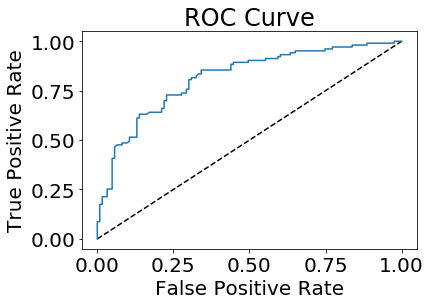

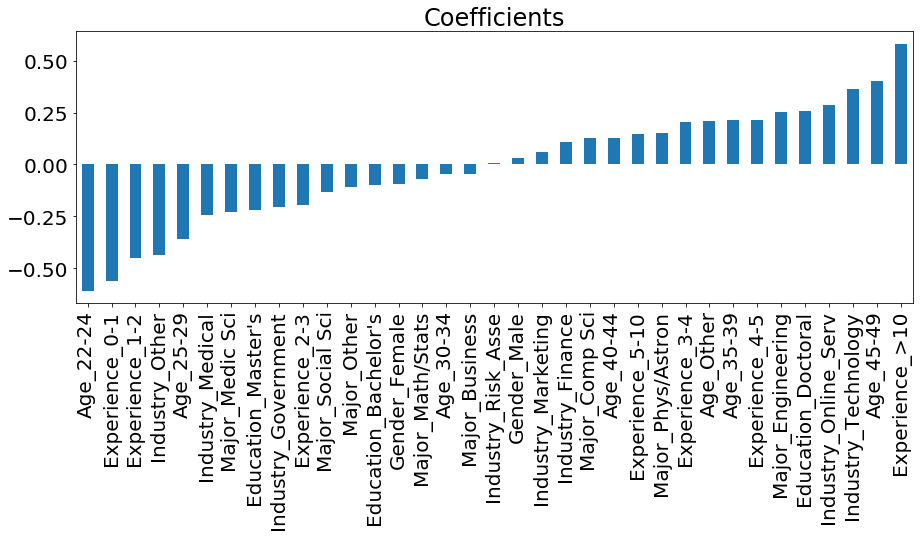


******** For i = 0.05 ******
Our testing accuracy is 0.4557522123893805
[[  0 123]
 [  0 103]]

******** For i = 0.1 ******
Our testing accuracy is 0.4557522123893805
[[  0 123]
 [  0 103]]

******** For i = 0.15 ******
Our testing accuracy is 0.4646017699115044
[[  3 120]
 [  1 102]]

******** For i = 0.2 ******
Our testing accuracy is 0.5353982300884956
[[ 20 103]
 [  2 101]]

******** For i = 0.25 ******
Our testing accuracy is 0.5973451327433629
[[37 86]
 [ 5 98]]

******** For i = 0.3 ******
Our testing accuracy is 0.672566371681416
[[59 64]
 [10 93]]

******** For i = 0.35 ******
Our testing accuracy is 0.7389380530973452
[[79 44]
 [15 88]]

******** For i = 0.4 ******
Our testing accuracy is 0.7256637168141593
[[86 37]
 [25 78]]

******** For i = 0.45 ******
Our testing accuracy is 0.7256637168141593
[[96 27]
 [35 68]]

******** For i = 0.5 ******
Our testing accuracy is 0.7389380530973452
[[107  16]
 [ 43  60]]

******** For i = 0.55 ******
Our testing accuracy is 0.7212389380

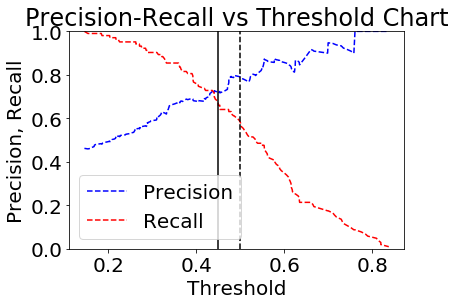

In [141]:
classify(clf, grid, x_categ, y, True)

In [55]:
df_fin = pd.concat([x_categ,y], axis=1)
features = list(x_categ.columns)
target = list(y.columns)
best = best_features(features, target, df_fin, 1000)
best[-1:]

['Education_Doctoral']

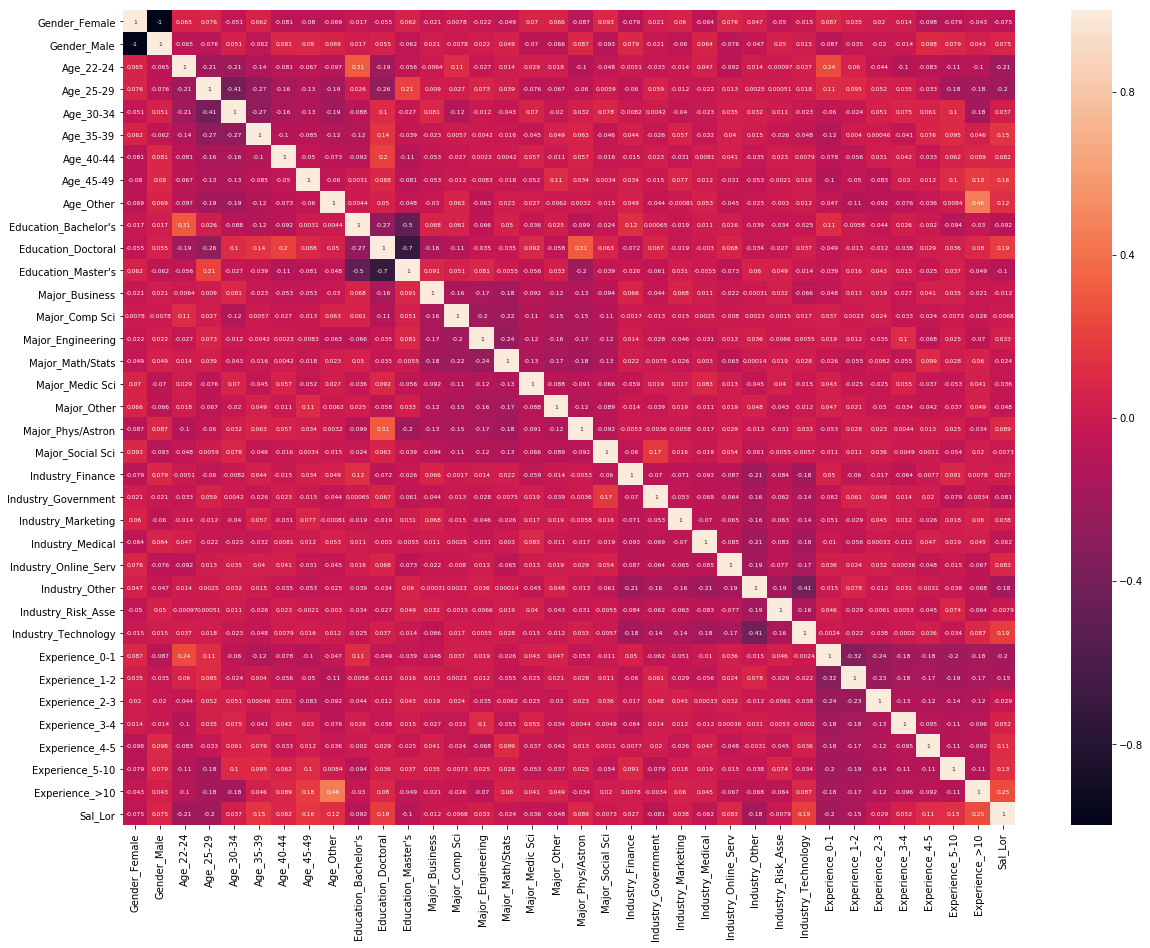

In [18]:
corr = df_fin.corr()
sns.heatmap(corr, xticklabels=corr.columns.values, 
            yticklabels=corr.columns.values, 
            annot = True, annot_kws={'size':6})
heat_map=plt.gcf()
heat_map.set_size_inches(20,15)
plt.xticks(fontsize=10)
plt.yticks(fontsize=10)
plt.show()

In [19]:
top_abs_corr(df_fin)

Gender_Female         Gender_Male             1.000000
Education_Doctoral    Education_Master's      0.700075
Education_Bachelor's  Education_Master's      0.499036
Age_Other             Experience_>10          0.455340
Industry_Other        Industry_Technology     0.414005
Age_25-29             Age_30-34               0.405051
Experience_0-1        Experience_1-2          0.324361
Age_22-24             Education_Bachelor's    0.308576
Education_Doctoral    Major_Phys/Astron       0.307895
Education_Bachelor's  Education_Doctoral      0.269437
Age_30-34             Age_35-39               0.266881
Age_25-29             Age_35-39               0.266016
                      Education_Doctoral      0.258781
Experience_>10        Sal_Lor                 0.253715
Age_22-24             Experience_0-1          0.243305
Major_Engineering     Major_Math/Stats        0.237949
Experience_0-1        Experience_2-3          0.237216
Experience_1-2        Experience_2-3          0.227186
Major_Comp

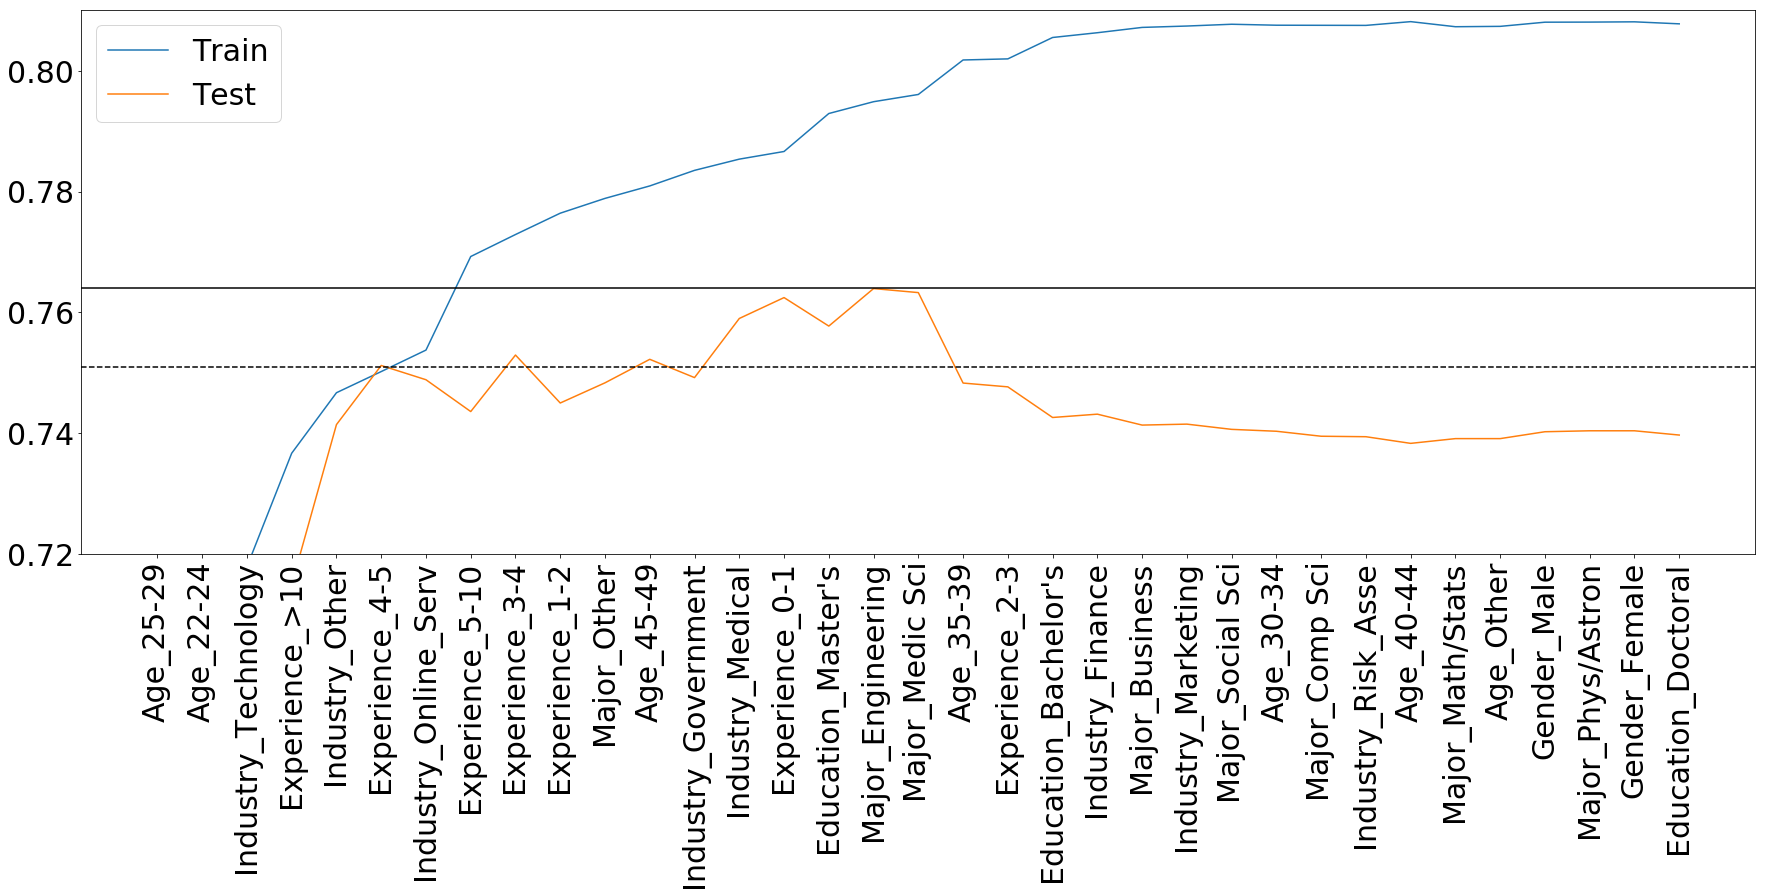

In [45]:
"""For Reducing Features"""

def auc_train_test(x, y, train_size=0.7):
    
    x_train, x_test, y_train, y_test = train_test_split(x, y, train_size=train_size, random_state=1)
    logreg = LogisticRegression()
    
    # Fit the model on train data
    logreg.fit(x_train, y_train)
    
    # Calculate the predictions both on train and test data
    predictions_train = logreg.predict_proba(x_train)[:,1]
    predictions_test = logreg.predict_proba(x_test)[:,1]
    
    # Calculate the AUC both on train and test data
    auc_train = roc_auc_score(y_train, predictions_train)
    auc_test = roc_auc_score(y_test, predictions_test)
    return(auc_train, auc_test)



auc_values_train = []
auc_values_test = []
features_evaluate = []
features = best

for feature in features:
    features_evaluate.append(feature)
    auc_train, auc_test = auc_train_test(x_categ[features_evaluate],y)
    auc_values_train.append(auc_train)
    auc_values_test.append(auc_test)
    
# Plot of AUC values
mpl.rcParams['font.size'] = 30.0
plt.figure(figsize=(30, 10))
x = np.array(range(0,len(auc_values_train)))
y_train = np.array(auc_values_train)
y_test = np.array(auc_values_test)
plt.xticks(x, features, rotation = 90)
plt.plot(x,y_train)
plt.plot(x,y_test)
plt.axhline(.751, color='k', linestyle='--')
plt.axhline(.764, color='k', linestyle='-')
plt.ylim((0.72, 0.81))
plt.legend(["Train","Test"],loc="upper left")
plt.show()